<a href="https://colab.research.google.com/github/min02yam/R-study/blob/main/220821.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.패키지 및 데이터 로드

In [216]:
system("gdown --id 1Op15dbRxlDyOtGTxrYvm88OcdBmo0dSL") # train
system("gdown --id 1B0tuhqv9KpxFYfy4ydNAACg8NpvhBa9N") # test
system("gdown --id 1lIwC3XpGx-bFP3wi9wNUeSOYkXaGwVoU") # sub

In [11]:
suppressPackageStartupMessages({
require(data.table)
require(magrittr)
require(dplyr)
require(lubridate)
require(stringr)
})

In [ ]:
install.packages("DataExplorer") # EDA
library(DataExplorer)
install.packages("skimr") # EDA
library(skimr)
install.packages("mice") # imputation
library(mice)
install.packages("ranger") # imputation
library(ranger)
install.packages("h2o") # modeling
require(h2o)
install.packages("caret")
library(caret)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [66]:
dt = fread("train.csv")

# 1.BASIC EDA

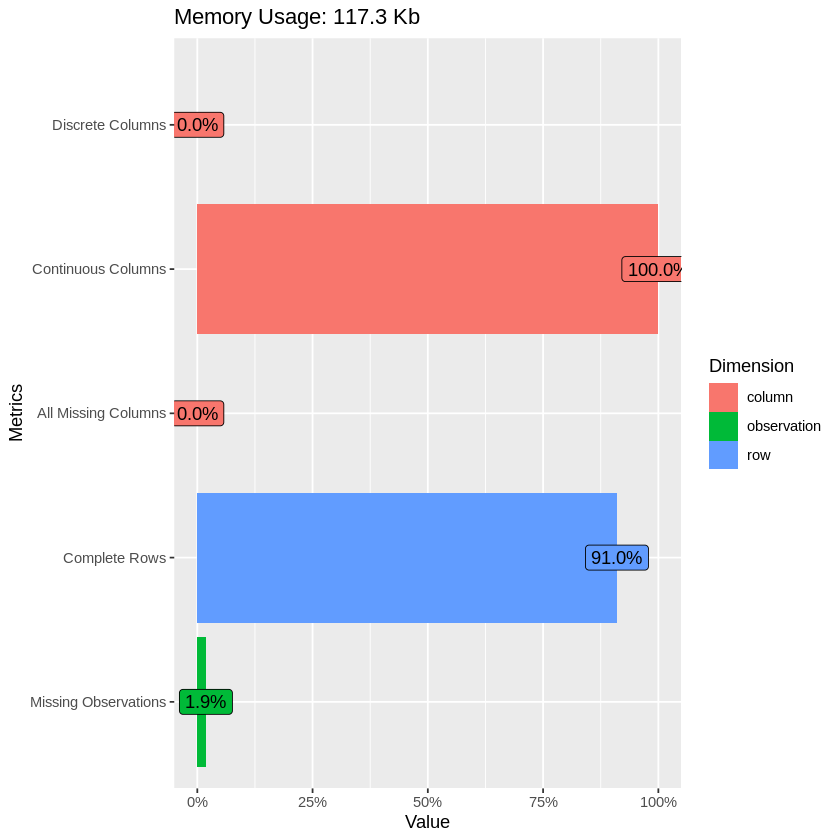

In [ ]:
plot_intro(dt)

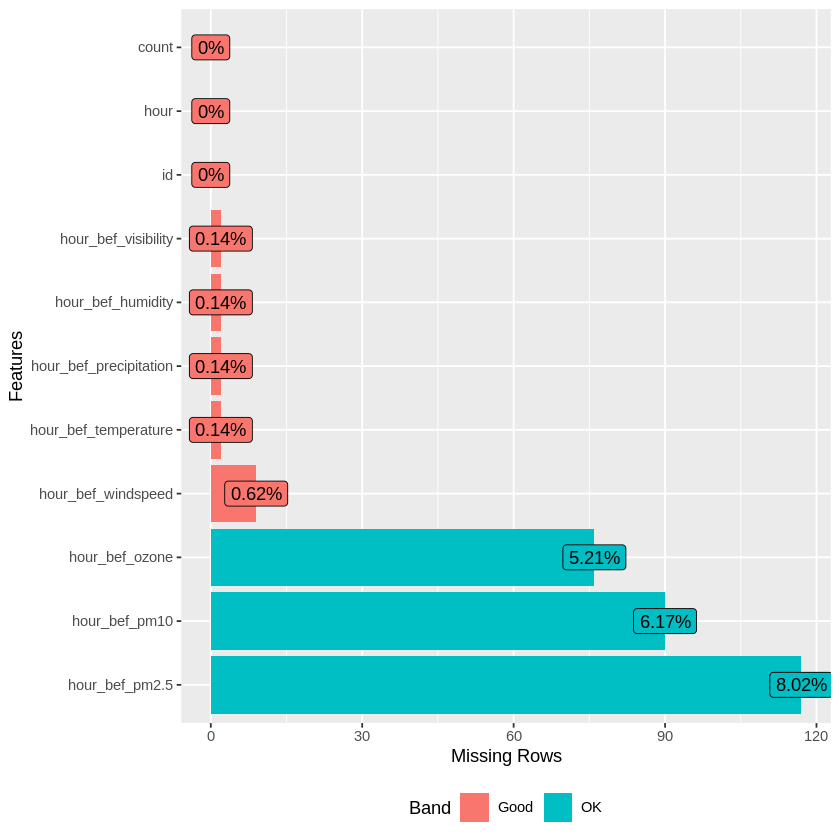

In [ ]:
plot_missing(dt)

In [ ]:
skim(dt)

── Data Summary ────────────────────────
                           Values
Name                       dt    
Number of rows             1459  
Number of columns          11    
Key                        NULL  
_______________________          
Column type frequency:           
  numeric                  11    
________________________         
Group variables            None  

── Variable type: numeric ──────────────────────────────────────────────────────
   skim_variable          n_missing complete_rate      mean       sd     p0
 1 id                             0         1     1106.     631.      3    
 2 hour                           0         1       11.5      6.92    0    
 3 hour_bef_temperature           2         0.999   16.7      5.24    3.1  
 4 hour_bef_precipitation         2         0.999    0.0316   0.175   0    
 5 hour_bef_windspeed             9         0.994    2.48     1.38    0    
 6 hour_bef_humidity              2         0.999   52.2     20.4     7    
 7 ho

1.  다 뉴메릭
2.  id, hour, count 변수 빼고 다 미싱 존재

## 1-1.라벨링

In [4]:
names(dt)

[1] "id"                     "hour"                   "hour_bef_temperature"  
 [4] "hour_bef_precipitation" "hour_bef_windspeed"     "hour_bef_humidity"     
 [7] "hour_bef_visibility"    "hour_bef_ozone"         "hour_bef_pm10"         
[10] "hour_bef_pm2.5"         "count"

In [75]:
dt %>% select(contains("hour_bef")) ->dt_selected
names(dt_selected) = str_sub(names(dt_selected),nchar("hour_bef_")+1)

In [74]:
dt %>% select(! contains("hour_bef")) -> dt_selected2

In [81]:
DT = cbind(dt_selected2, dt_selected)
DT = DT[,c(1:2,4:11,3)] # 순서 변경

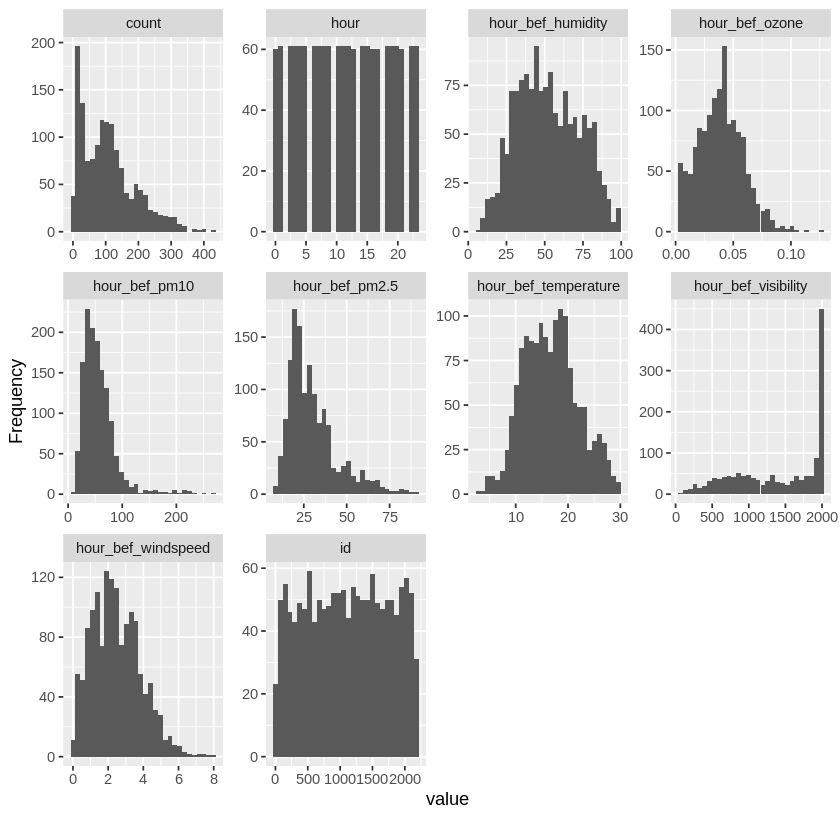

In [ ]:
plot_histogram(DT)

# 2.이상치 처리 및 결측치 대체
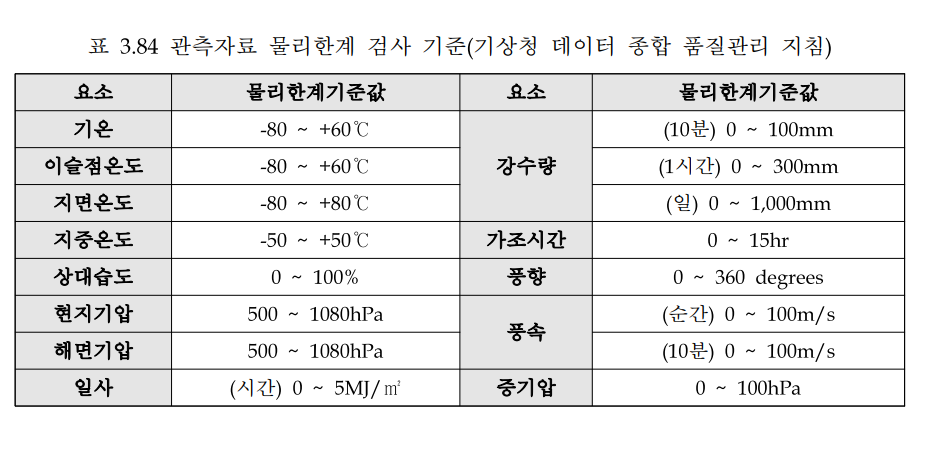

도메인으로 봤을때 이상치가 없다고 판단하고, 대기환경 변수만 0.999퀀타일 값을 기준으로 결측치로 처리함 

In [ ]:
boxplot(DT[,8], main=names(DT[,8]))
boxplot(DT[,9])
boxplot(DT[,10])

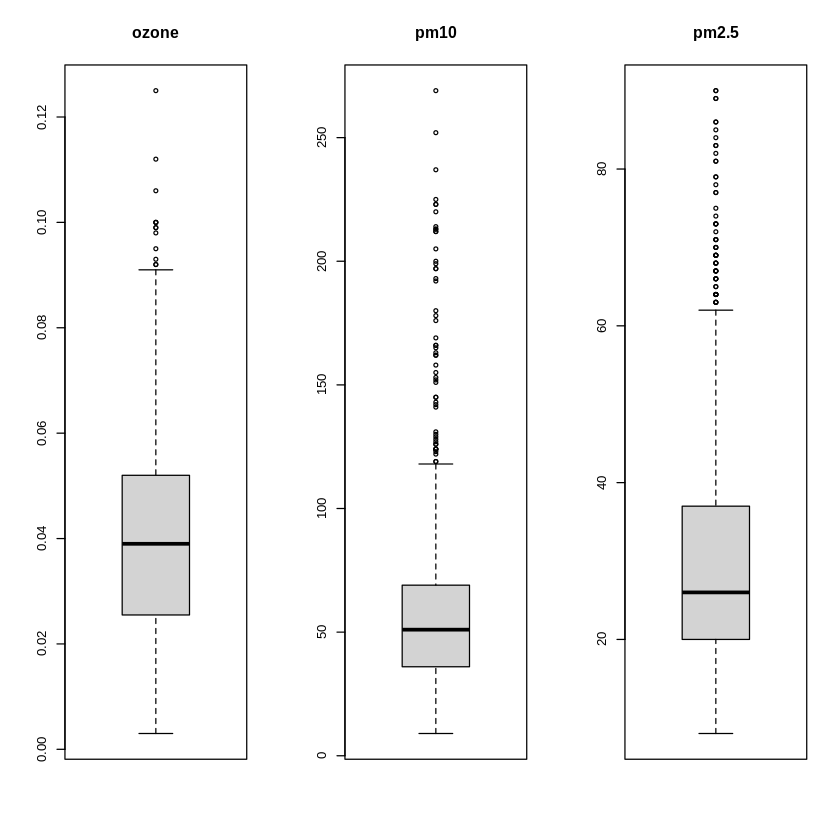

In [98]:
par(mfrow=c(1,3))
boxplot(DT[,8], main=names(DT[,8]))
boxplot(DT[,9], main=names(DT[,9]))
boxplot(DT[,10], main=names(DT[,10]))

In [101]:
#step1. 포텐셜 아웃라이어 결측치로 처리
ozone_out = quantile(DT[,'ozone'], probs=c(0.999), na.rm=TRUE)
pm10_out = quantile(DT[,'pm10'], probs=c(0.999), na.rm=TRUE)
pm25_out = quantile(DT[,'pm2.5'], probs=c(0.999), na.rm=TRUE)

DT[ozone > ozone_out, ozone:=NA ]
DT[pm10 > pm10_out, pm10:=NA ]
DT[pm2.5 > pm25_out, pm2.5:=NA ]

colSums(is.na(DT))

In [122]:
#step2. 결측치 대체
tmp = mice(DT,
  m=5,
  meth='pmm',
  seed=2022)
summary(tmp)


 iter imp variable
  1   1  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  1   2  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  1   3  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  1   4  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  1   5  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  2   1  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  2   2  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  2   3  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  2   4  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  2   5  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  3   1  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
 

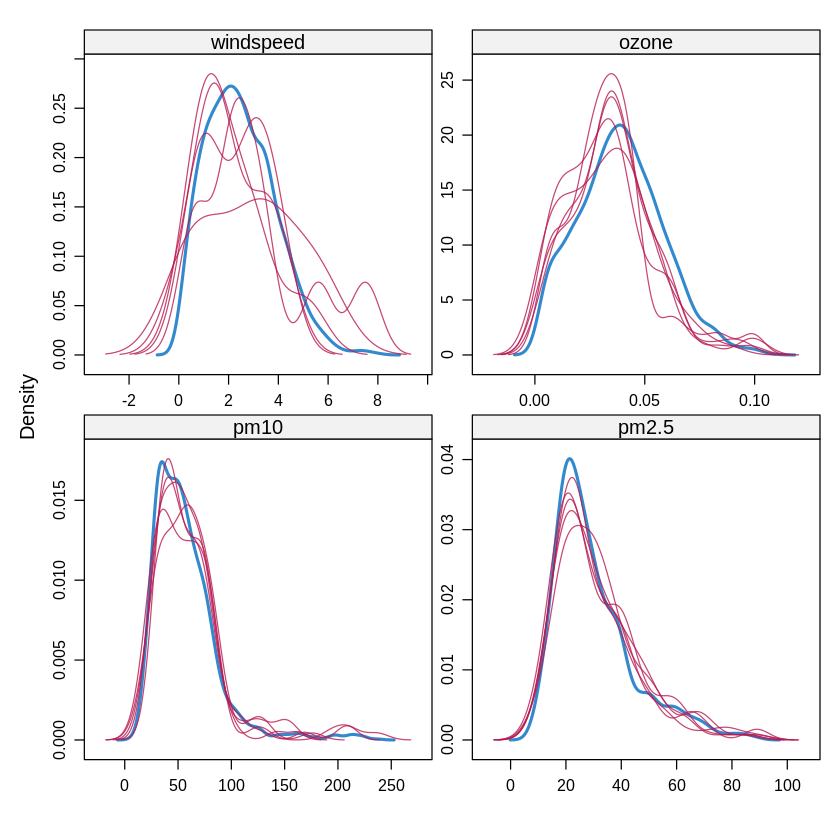

In [123]:
densityplot(tmp)


 iter imp variable
  1   1  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  1   2  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  1   3  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  1   4  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  1   5  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  2   1  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  2   2  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  2   3  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  2   4  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  2   5  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  3   1  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
 

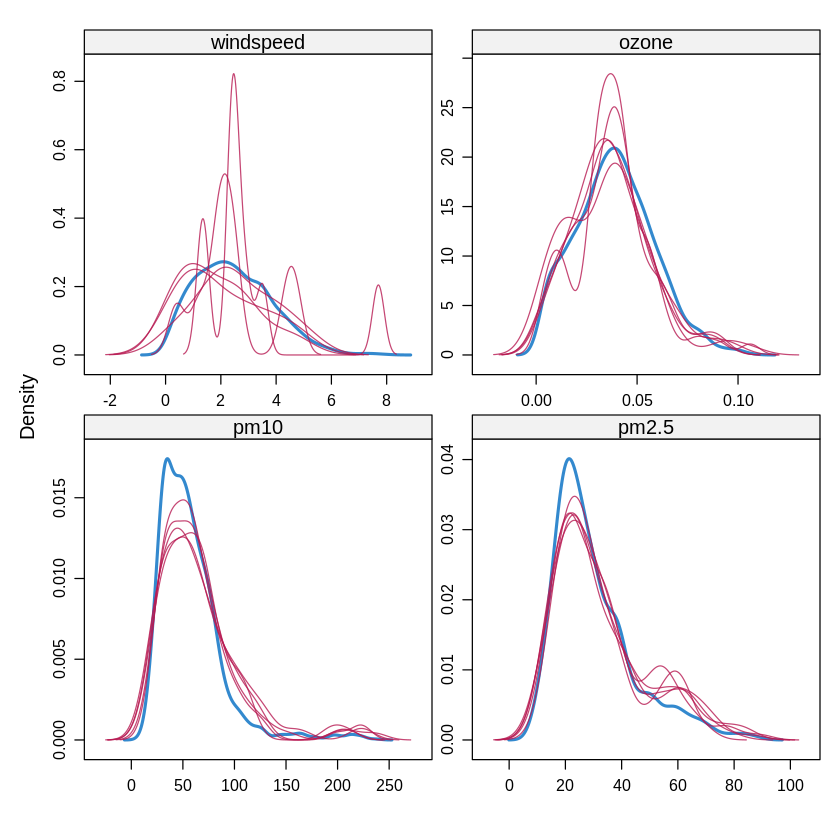

In [121]:
tmp_cart = mice(DT,
  m=5,
  meth='cart',
  seed=2022)
densityplot(tmp_cart)


 iter imp variable
  1   1  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  1   2  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  1   3  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  1   4  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  1   5  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  2   1  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  2   2  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  2   3  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  2   4  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  2   5  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  3   1  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
 

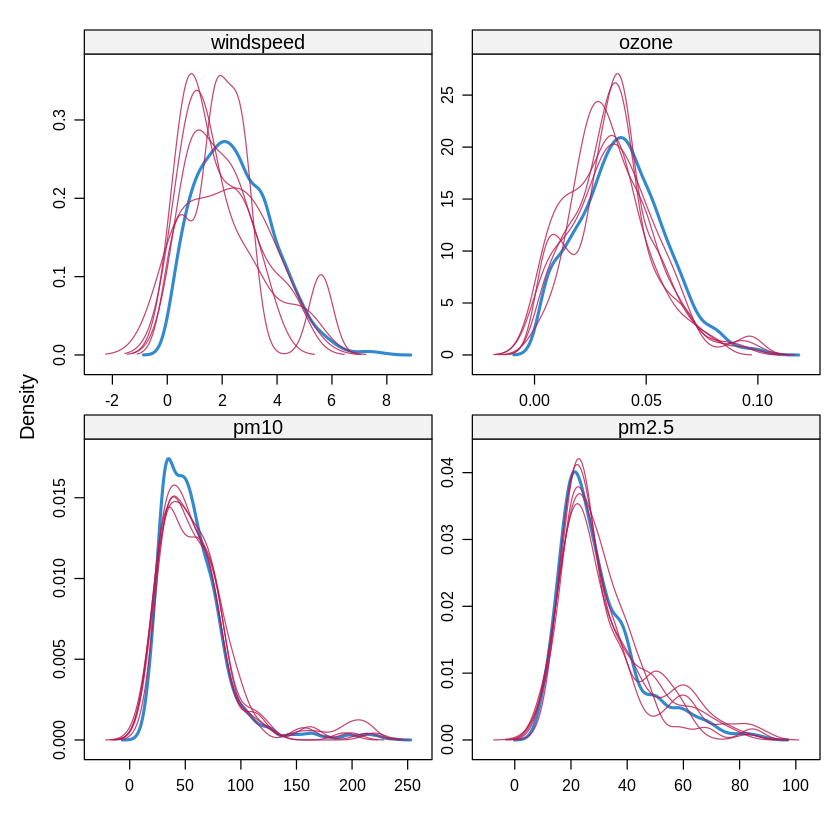

In [128]:
tmp_rf = mice(DT,
  m=5,
  meth='rf',
  seed=2022)
densityplot(tmp_rf)

In [129]:
cmp = complete(tmp,1)

In [167]:
#스케일링
min_max_norm = preProcess(cmp[,-11], method = c("range"))
train = predict(min_max_norm, cmp)
train %>% summary

       id              hour         temperature     precipitation    
 Min.   :0.0000   Min.   :0.0000   Min.   :0.0000   Min.   :0.00000  
 1st Qu.:0.2539   1st Qu.:0.2391   1st Qu.:0.3606   1st Qu.:0.00000  
 Median :0.5110   Median :0.4783   Median :0.5019   Median :0.00000  
 Mean   :0.5069   Mean   :0.4997   Mean   :0.5061   Mean   :0.03153  
 3rd Qu.:0.7574   3rd Qu.:0.7609   3rd Qu.:0.6301   3rd Qu.:0.00000  
 Max.   :1.0000   Max.   :1.0000   Max.   :1.0000   Max.   :1.00000  
   windspeed         humidity        visibility         ozone       
 Min.   :0.0000   Min.   :0.0000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.1750   1st Qu.:0.3152   1st Qu.:0.4168   1st Qu.:0.2136  
 Median :0.2875   Median :0.4783   Median :0.7799   Median :0.3398  
 Mean   :0.3095   Mean   :0.4918   Mean   :0.6905   Mean   :0.3477  
 3rd Qu.:0.4250   3rd Qu.:0.6739   3rd Qu.:0.9969   3rd Qu.:0.4660  
 Max.   :1.0000   Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  
      pm10            pm2.5

# 3.모델링

In [204]:
#h2o.shutdown() 
h2o.init(max_mem_size = "4g", nthreads = 5)  


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/RtmpskiCXG/file4e6d14e206/h2o_UnknownUser_started_from_r.out
    /tmp/RtmpskiCXG/file4e587c23e5/h2o_UnknownUser_started_from_r.err


Starting H2O JVM and connecting: ... Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 seconds 86 milliseconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.36.1.2 
    H2O cluster version age:    2 months and 25 days  
    H2O cluster name:           H2O_started_from_R_root_okp913 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   4.00 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    R Version:     

In [205]:
# variable importance 산출하기
data.hex = as.h2o(train)
x = names(data.hex)[!(colnames(data.hex) %in% c("id","hour","count"))]
y = "count" #y값 설정

fit = h2o.randomForest(x=x,
  y=y,
  training_frame= data.hex,
  ntrees = 50, 
  max_depth = 20, 
  seed = 2022)

varimp  = h2o.varimp(fit) # variable importance
varimp 

  |======================================================================| 100%
  |======================================================================| 100%


variable,relative_importance,scaled_importance,percentage
<chr>,<dbl>,<dbl>,<dbl>
temperature,105257928,1.00000000,0.30264651
windspeed,59963672,0.56968319,0.17241263
ozone,58375472,0.55459454,0.16784610
humidity,46367000,0.44050839,0.13331832
visibility,28337818,0.26922265,0.08147929
pm10,23144432,0.21988303,0.06654683
pm2.5,22045710,0.20944465,0.06338769
precipitation,4299616,0.04084839,0.01236262


# 4.파라미터 튜닝

In [207]:
#하이퍼파라미터 조합만들기
prm = list(sample_rate = c(0.3,0.4), 
  max_depth=c(18,20,25), 
  ntrees=c(25,50),
  mtries=c(-1,1))
#조합 모형 돌리기
m = h2o.grid(algorithm="randomForest",
  grid_id="rf_grid",
  training_frame = data.hex,
  x = x,
  y = y,
  hyper_params=prm)
#rmse가 낮은 순으로 정렬하기
grid = h2o.getGrid(grid_id = "rf_grid", sort_by = "rmse")
grid_df = as.data.frame(grid@ summary_table)
head(grid_df)
#베스트 모형 선택
best_model = h2o.getModel(grid@model_ids[[1]])
summary(best_model)

  |======================================================================| 100%


,max_depth,mtries,ntrees,sample_rate,model_ids,rmse
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,18,-1,50,0.4,rf_grid_model_19,53.64713
2,20,-1,50,0.4,rf_grid_model_20,53.79271
3,25,-1,50,0.3,rf_grid_model_9,54.18530
4,18,-1,50,0.3,rf_grid_model_7,54.29947
5,20,-1,50,0.3,rf_grid_model_8,54.34014
6,25,-1,50,0.4,rf_grid_model_21,54.34902


Model Details:

H2ORegressionModel: drf
Model Key:  rf_grid_model_19 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1              50                       50              355963        17
  max_depth mean_depth min_leaves max_leaves mean_leaves
1        18   17.96000        506        595   562.46000

H2ORegressionMetrics: drf
** Reported on training data. **
** Metrics reported on Out-Of-Bag training samples **

MSE:  2878.015
RMSE:  53.64713
MAE:  41.51683
RMSLE:  0.7791999
Mean Residual Deviance :  2878.015





Scoring History: 
            timestamp   duration number_of_trees training_rmse training_mae
1 2022-08-21 09:10:19  6.723 sec               0            NA           NA
2 2022-08-21 09:10:19  6.735 sec               1      76.90588     57.40998
3 2022-08-21 09:10:19  6.745 sec               2      72.44599     53.45781
4 2022-08-21 09:10:19  6.756 sec               3      69.12467     51.28321
5 2022-08-21 09:10:19  6.767 sec     

1. 	25	-1	50	0.4	rf_grid_model_21	53.15546

# 5.피팅

In [165]:
colSums(is.na(TEST))

id          hour   temperature precipitation     windspeed 
            0             0             1             1             1 
     humidity    visibility         ozone          pm10         pm2.5 
            1             1            35            37            36

In [208]:
#검증 생략
test = fread("test (2).csv")
test %>% select(contains("hour_bef")) ->test_selected
names(test_selected) = str_sub(names(test_selected),nchar("hour_bef_")+1)
test %>% select(! contains("hour_bef")) -> test_selected2
TEST = cbind(test_selected2, test_selected)

In [210]:
colSums(is.na(TEST))

id          hour   temperature precipitation     windspeed 
            0             0             1             1             1 
     humidity    visibility         ozone          pm10         pm2.5 
            1             1            35            37            36

In [211]:
#step1. 포텐셜 아웃라이어 결측치로 처리
ozone_out = quantile(TEST[,'ozone'], probs=c(0.999), na.rm=TRUE)
pm10_out = quantile(TEST[,'pm10'], probs=c(0.999), na.rm=TRUE)
pm25_out = quantile(TEST[,'pm2.5'], probs=c(0.999), na.rm=TRUE)

TEST[ozone > ozone_out, ozone:=NA ]
TEST[pm10 > pm10_out, pm10:=NA ]
TEST[pm2.5 > pm25_out, pm2.5:=NA ]

#step2. 결측치 대체
tmp = mice(TEST,
  m=5,
  meth='pmm',
  seed=2022)
summary(tmp)

t_cmp = complete(tmp,1)

#스케일링
test = predict(min_max_norm, t_cmp)


 iter imp variable
  1   1  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  1   2  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  1   3  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  1   4  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  1   5  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  2   1  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  2   2  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  2   3  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  2   4  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  2   5  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
  3   1  temperature  precipitation  windspeed  humidity  visibility  ozone  pm10  pm2.5
 

In [213]:
best_model

Model Details:

H2ORegressionModel: drf
Model ID:  rf_grid_model_19 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1              50                       50              355963        17
  max_depth mean_depth min_leaves max_leaves mean_leaves
1        18   17.96000        506        595   562.46000


H2ORegressionMetrics: drf
** Reported on training data. **
** Metrics reported on Out-Of-Bag training samples **

MSE:  2878.015
RMSE:  53.64713
MAE:  41.51683
RMSLE:  0.7791999
Mean Residual Deviance :  2878.015





In [214]:
#피팅
test.hex = as.h2o(test)
pred = h2o.predict(best_model, test.hex)

  |======================================================================| 100%
  |======================================================================| 100%


In [217]:
sub = fread("submission.csv")

In [222]:
hat = as.data.frame(pred$predict)
sub[,'count'] = hat

In [226]:
write.csv(sub, "sub_rf.csv", row.names=FALSE)

In [227]:
#파일 내보내기
write.csv(cmp, "train_fi.csv", row.names=FALSE)
write.csv(t_cmp, "test_fi.csv", row.names=FALSE)